In [2]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating Data on LUMI

In [4]:
from GENE_ML.gene_ml.samplers.uniform import Uniform
from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
from GENE_ML.gene_ml.runners.GENErunner import GENErunner
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

import os
import sys
sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))


parameters = ['_grp_species_1-omt', '_grp_species_0-omt']
bounds = [(4,6.7), (2.1,3.5)] #if bounds is a float rather than tuple then the sampler will make that the only value

#Working fine
# parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
# bounds = [(0.05,1), (10,70), (5,60)]

num_samples = 5
sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

##Parser
#The parsers main function is write_input_file
# wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
#  It will then create a parameters file that can scan over all the points.
base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')
remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/test'
save_dir = "/temp"
parser = GENE_scan_parser(save_dir, base_params_path, remote_save_dir)

## Runner
#The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# code_run will take the set of points named samples and parse them into a parameters file.
#  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
sbatch_base_path = os.path.join('sbatch_base')
guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
remote_run_dir = '/project/project_462000451/gene/'
runner = GENErunner(parser, host, sbatch_base_path, guess_sample_wallseconds, remote_run_dir)

##Executor
#The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# The executor should alter a base batch script to account for that less samples will be ran. 
num_workers = 1
executor = ScanExecutor(num_workers, sampler, runner, remote_save_dir=remote_save_dir)

In [5]:
#executor.start_runs()

# Pulling Data from LUMI

The data loaded was created by scanning over ion and electron temperature gradients within their margin of uncertainty. 

In [7]:
from GENE_ML.gene_ml.dataset.ScanData import ScanData
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

parser = GENE_scan_parser(save_dir)

host = 'lumi'
#data_name = f'{num_samples}s_{len(parameters)}p_uq'#'1000s_2p_uq'
data_name = '1000s_3p_uq'
test_percentage=50
# data_set = ScanData(data_name, parser, host, remote_path=remote_save_dir, test_percentage=test_percentage)

#If the data is already loaded from the remote to local .../scanlogs/<data_name> then the host and remote path can be ommitted
data_set = ScanData(data_name, parser, test_percentage=test_percentage)

data_set.remove_parameter('kymin1')
data_set.df

Initialising dataset
SSH PATH None:None

LOADING FROM SCANLOG DIR

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___0.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___1.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___2.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___3.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___4.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___5.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___6.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___7.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___8.log

LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___9.log

496 SAMPLES RAN OUT OF 1000 BEFORE MAX WALLTIME:
NUMBER OF SAMPLES AFTER 

,omt2,omt1,growthrate,frequency
0,4.499231,3.205307,0.0630,0.0280
1,4.539037,2.281065,0.0290,0.0190
2,6.083308,2.551308,0.0420,-0.1240
3,5.836209,2.267819,0.0400,-0.1250
4,5.275577,2.353216,0.0300,0.0180
...,...,...,...,...
92,4.055202,2.212065,0.0270,0.0190
93,5.374778,2.930346,0.0510,0.0210
94,6.637011,3.115819,0.0550,0.0190
95,5.426347,3.169864,0.0600,0.0230


In [8]:
# for i in range(len(data_set.x)):
#     print(data_set.x[i], sampler.samples_np[i])
#     print(i)
    

sampler.samples_np



array([[4.49923125, 3.38134112],
       [4.53903687, 3.11669154],
       [6.08330815, 2.19653047],
       [5.83620935, 2.88223119],
       [5.27557747, 3.3197883 ]])

# Training Surrogate Model 

In [9]:
import os
from GENE_ML.gene_ml.models.GPR import GPR
from GENE_ML.gene_ml.results.results import Results

#numsamples_numparameters_model_testpercentage
model_name = 'GPR'
results_gpr_name = 'uq_results_1000s_2p_GPR_50tp'
#results_gpr_name = f'uq_results_{num_samples}s_{len(parameters)}p_{model_name}_{test_percentage}tp' #
results_gpr = Results(results_gpr_name)
gpr = GPR(name = model_name)
print(gpr.parent)
if os.path.exists(results_gpr.path) and os.path.exists(gpr.path):
    print('\nLOADING RESULTS FROM FILE\n')
    results_gpr = results_gpr.load()
    print(f'{results_gpr.name} IS LOADED')
    gpr = gpr.load()
else:
    print('\nCOMPUTING RESULTS\n')
    #Sampling already done, gene has been ran
    gpr.train(data_set.x_train, data_set.growthrate_train)
    gpr.tune_hypers(data_set.x_train, data_set.growthrate_train)

    results_gpr.growthrate_predict_seen, growthrate_predict_seen_errors = gpr.predict(data_set.x_train)
    results_gpr.growthrate_predict_unseen, growthrate_predict_unseen_errors = gpr.predict(data_set.x_test)

    results_gpr.save()

parent

COMPUTING RESULTS

GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : 228.50846984119326
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
OPTIMISING THE HYPERPERS:
Optimization restart 1/3, f = -1385.8392243985281
Optimization restart 2/3, f = -1385.8392244181075
Optimization restart 3/3, f = -1385.8392244200982
RESULTING HYPERS:
 
Name : GP regression
Objective : -1385.8392244200982
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors


NO UNCERTAINTY PROVIDED
NO UNCERTAINTY PROVIDED


 /tmp/ipykernel_293818/540111191.py:20: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


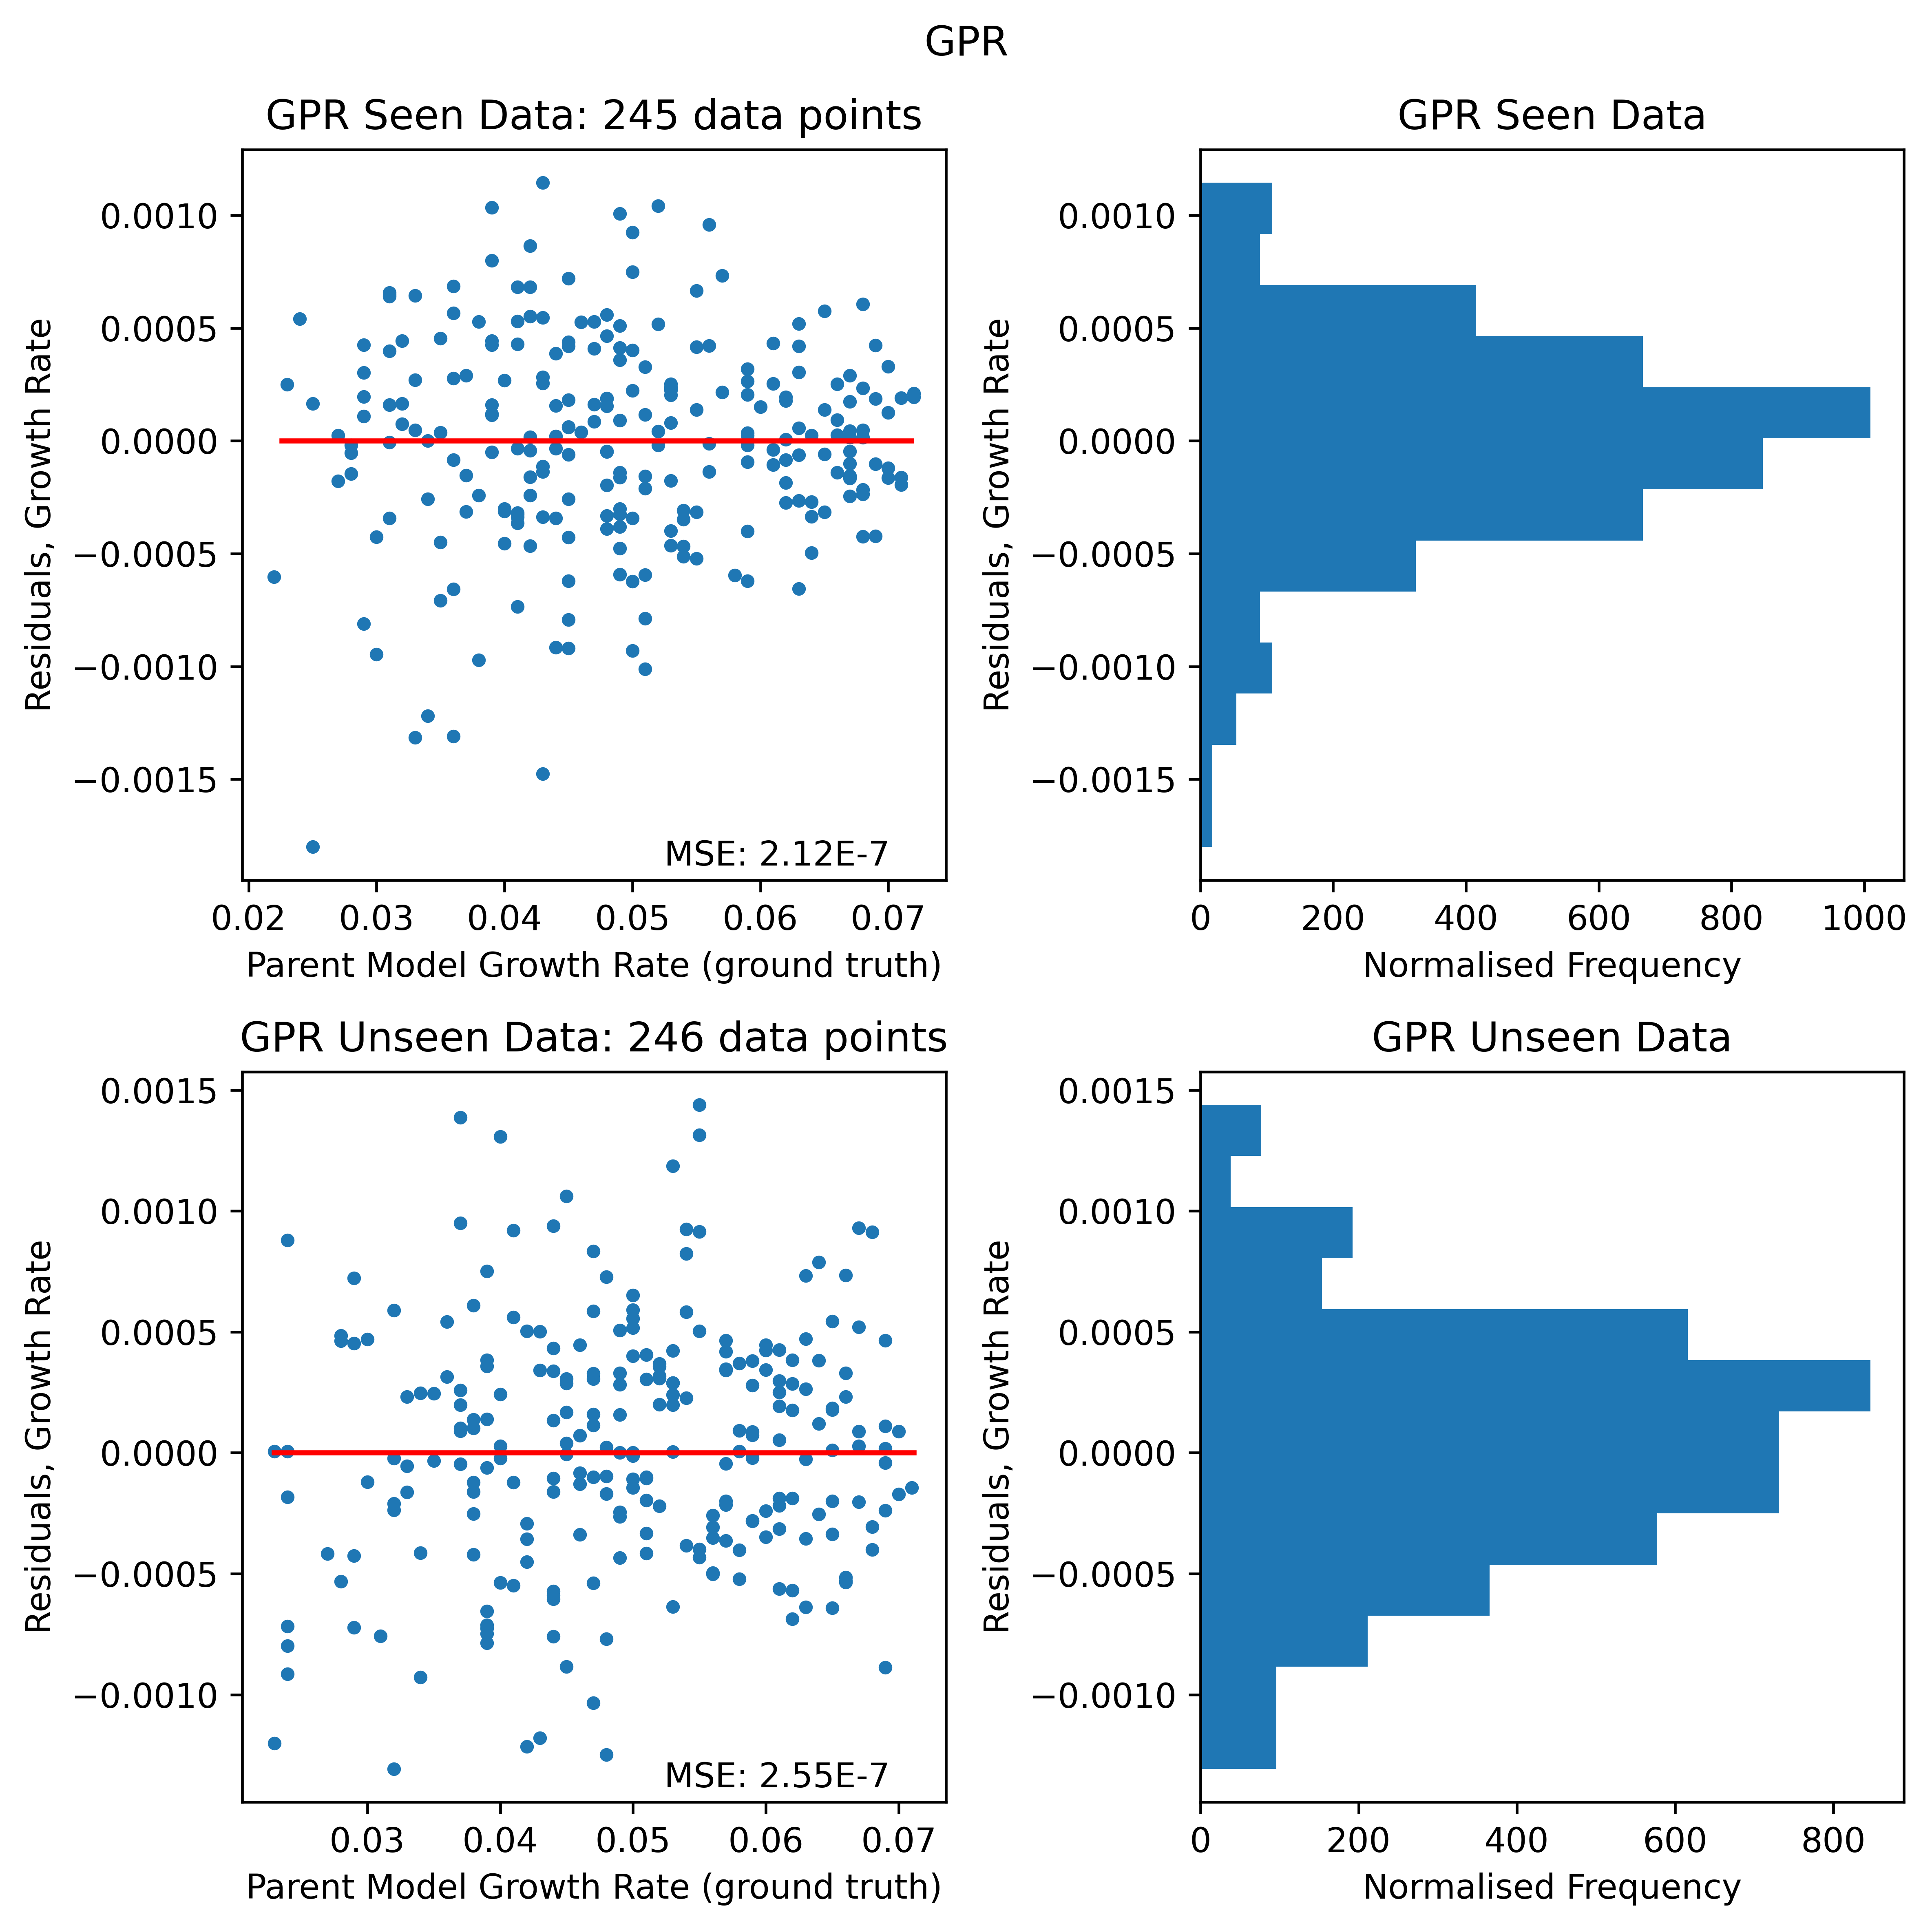

In [10]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol=2
nrow=2
size=4
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow), dpi=600)
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')#, y_pred_err=growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', bins=13)

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')#, y_pred_err=growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', bins=13)

# ax4.sharex(ax2)

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()

In [11]:
import numpy as np
from GENE_ML.gene_ml.samplers.gaussian import Gaussian

num_samples_g = 100000
gaussian = Gaussian(bounds, num_samples_g, parameters)

gaussian.samples_np

array([[4.80623344, 2.50723587],
       [4.68385044, 2.87420084],
       [5.57583114, 2.37410619],
       ...,
       [5.09055347, 2.94684222],
       [5.31674976, 2.37283913],
       [4.53815407, 2.68840375]])

In [18]:
print(gaussian.samples_np.shape)
print(data_set.x_train.shape)



(100000, 2)
(245, 2)


(100000, 1)
[[0.03695816]
 [0.05068729]
 [0.03394816]
 ...
 [0.05228702]
 [0.03153391]
 [0.0445045 ]]
[[4.742492 2.346237]
 [6.352449 3.304948]
 [4.281945 3.20599 ]
 [5.081738 3.418054]
 [6.094214 2.248557]
 [4.686074 2.306909]
 [4.066328 2.778522]
 [5.987598 2.279751]
 [5.362552 3.369501]
 [4.437564 2.133738]]
[0.031 0.062 0.063 0.07  0.045 0.029 0.049 0.043 0.067 0.023]
SHAPE (1, 2) (245, 2)
(1, 1)
[[0.04685942]]
(1, 1)
[[0.0233398]]
(1, 1)
[[0.06844101]]


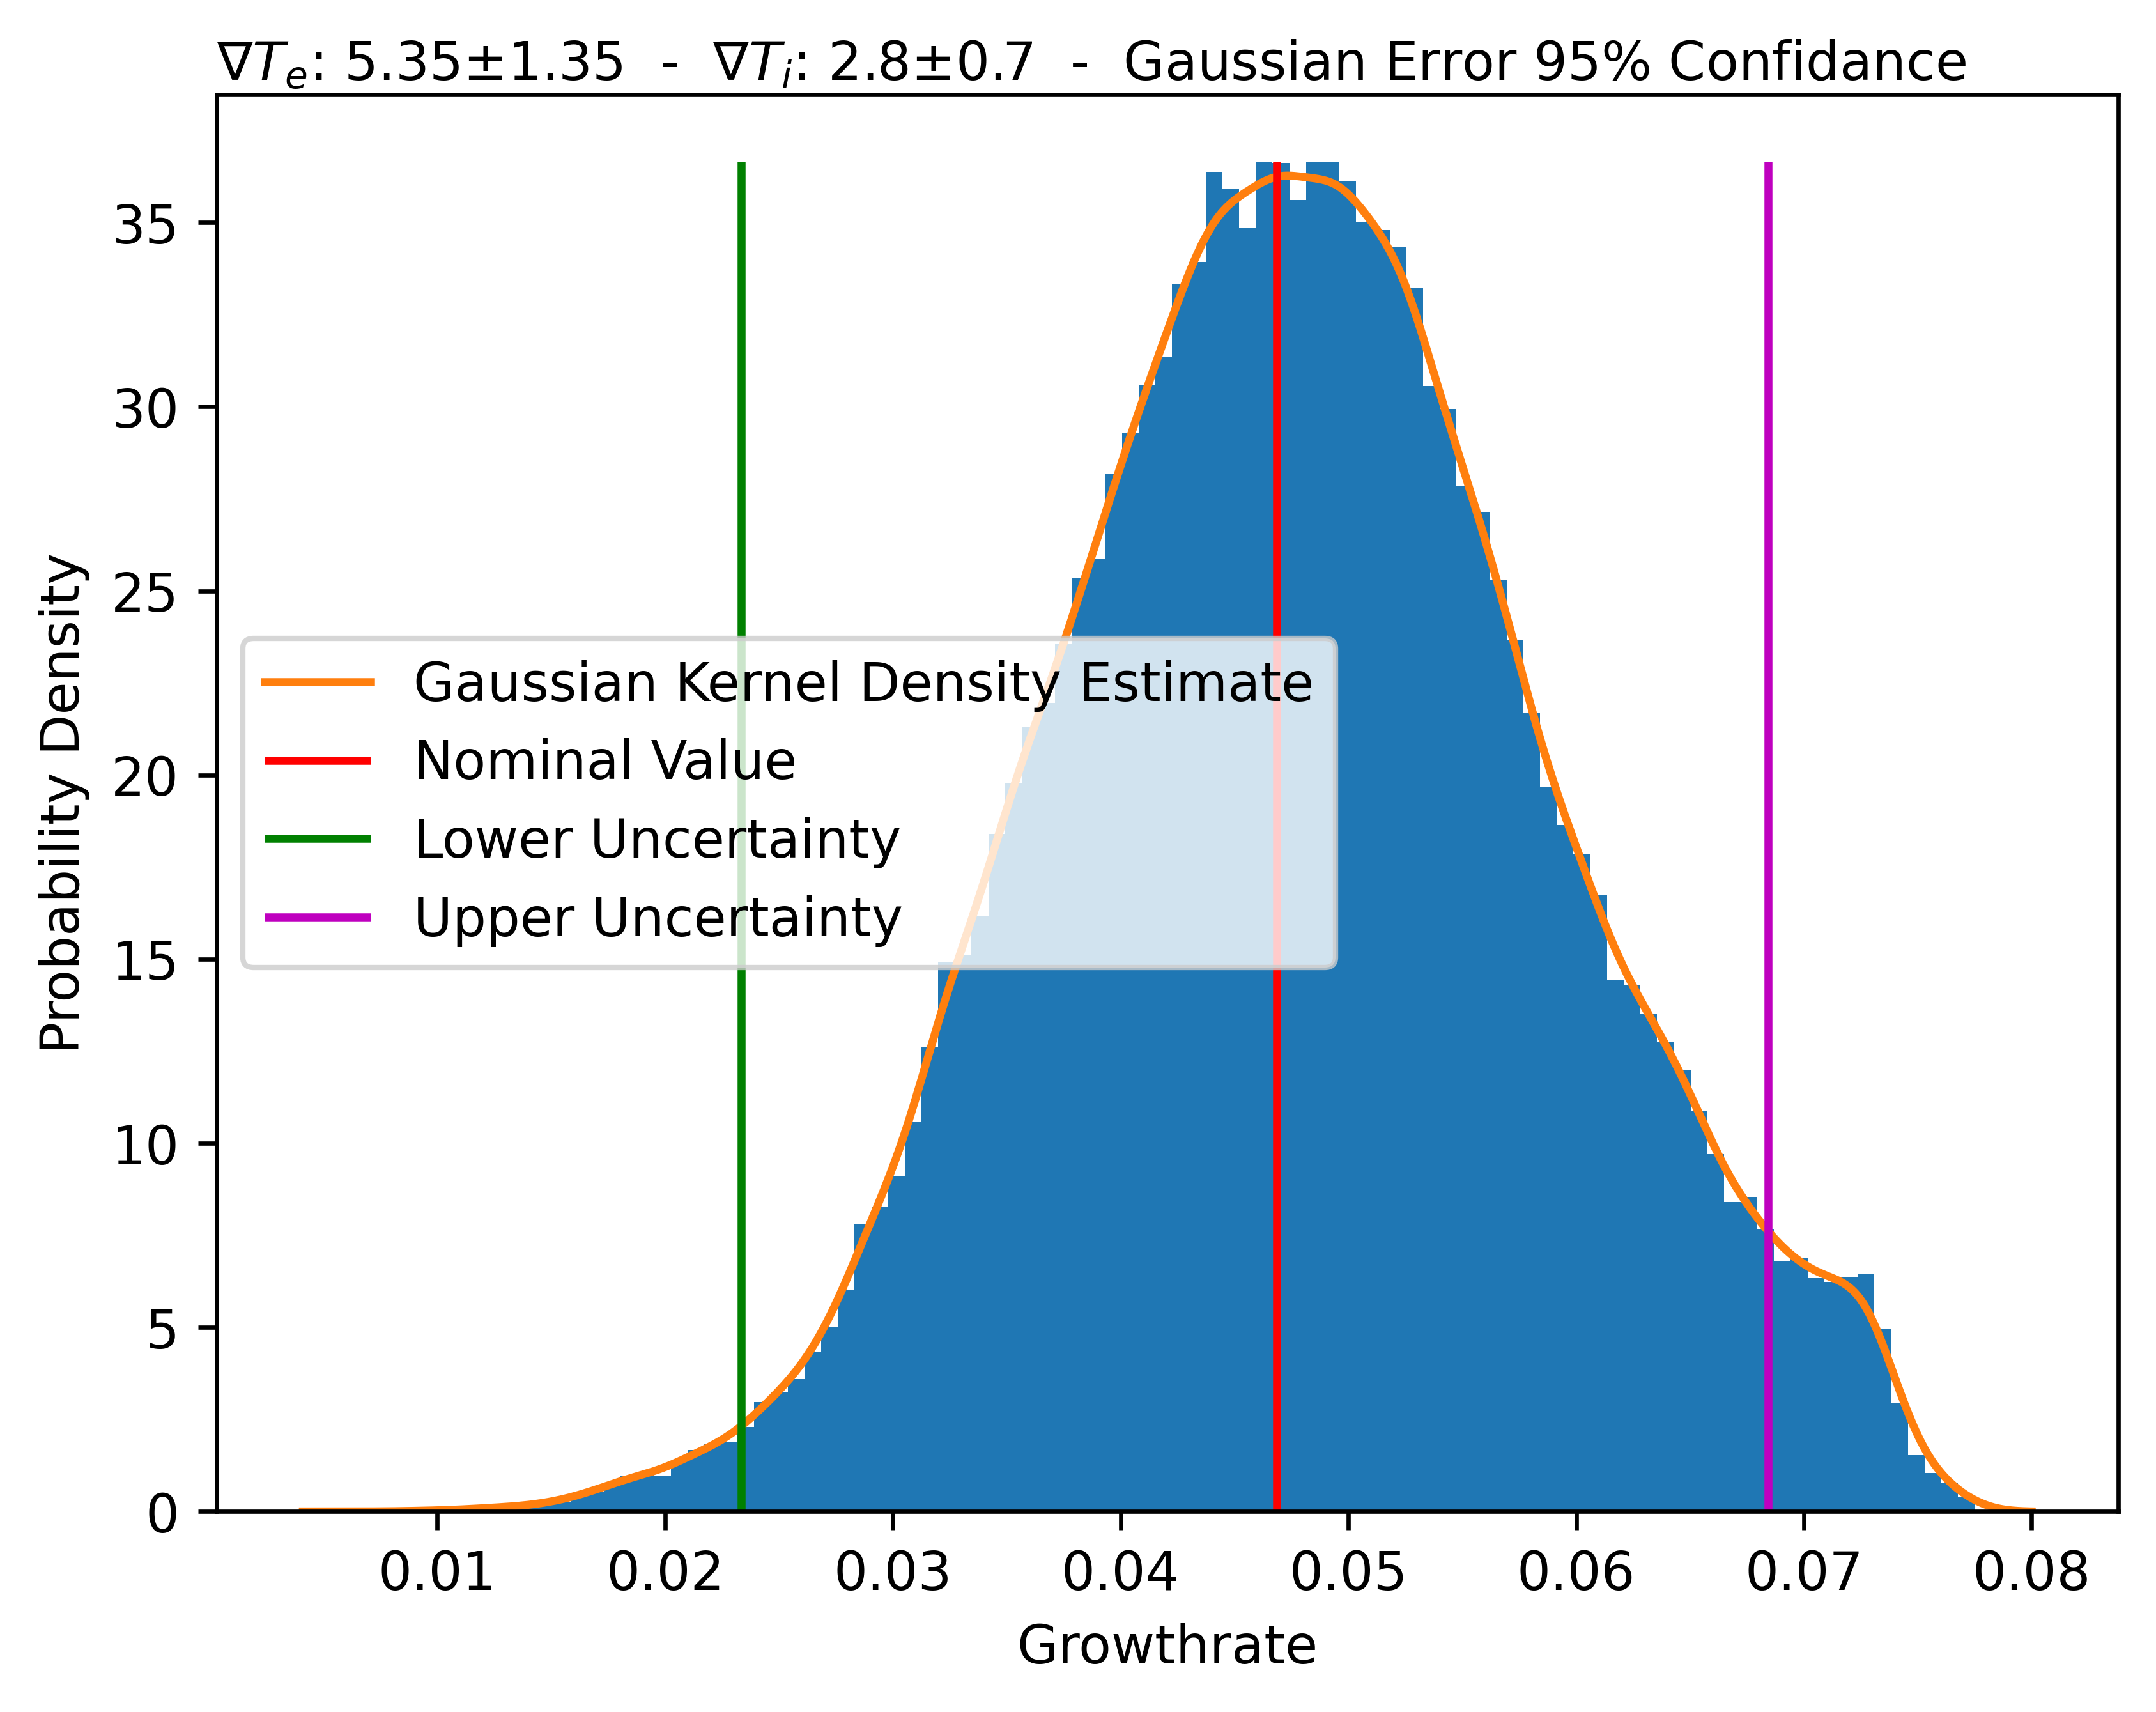

In [19]:
from scipy import stats
growthrates, _ = gpr.predict(gaussian.samples_np)
print(data_set.x_train[0:10])
print(data_set.growthrate_train[0:10])

bounds = [(4,6.7), (2.1,3.5)]
nominal_parameters = np.array([np.mean(b) for b in bounds]).reshape((2,1)).T
print('SHAPE', nominal_parameters.shape, data_set.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds]).reshape(2,1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds]).reshape(2,1).T)

fig = plt.figure(dpi=600)
kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),0.08, 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Uncertainty')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Uncertainty')
plt.annotate(fr'$\nabla T_e$: {nominal_parameters[0][0]}$\pm$1.35  -  $\nabla T_i$: {nominal_parameters[0][1]}$\pm$0.7  -  Gaussian Error 95% Confidance',
            xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()


In [20]:
import numpy as np
from GENE_ML.gene_ml.samplers.uniform import Uniform

num_samples_u = 100000
uniform = Uniform(bounds, num_samples_u, parameters)

uniform.samples_np.shape

(100000, 2)

 <>:22: SyntaxWarning:invalid escape sequence '\p'
 <>:22: SyntaxWarning:invalid escape sequence '\p'
 <>:22: SyntaxWarning:invalid escape sequence '\p'
 <>:22: SyntaxWarning:invalid escape sequence '\p'
 /tmp/ipykernel_293818/2248310182.py:22: SyntaxWarning:invalid escape sequence '\p'
 /tmp/ipykernel_293818/2248310182.py:22: SyntaxWarning:invalid escape sequence '\p'


(100000, 1)
[[0.04286835]
 [0.04291196]
 [0.04245636]
 ...
 [0.05441055]
 [0.05676641]
 [0.03190693]]
[[4.742492 2.346237]
 [6.352449 3.304948]
 [4.281945 3.20599 ]
 [5.081738 3.418054]
 [6.094214 2.248557]
 [4.686074 2.306909]
 [4.066328 2.778522]
 [5.987598 2.279751]
 [5.362552 3.369501]
 [4.437564 2.133738]]
[0.031 0.062 0.063 0.07  0.045 0.029 0.049 0.043 0.067 0.023]
SHAPE (1, 2) (245, 2)
(1, 1)
[[0.04685942]]
(1, 1)
[[0.0233398]]
(1, 1)
[[0.06844101]]


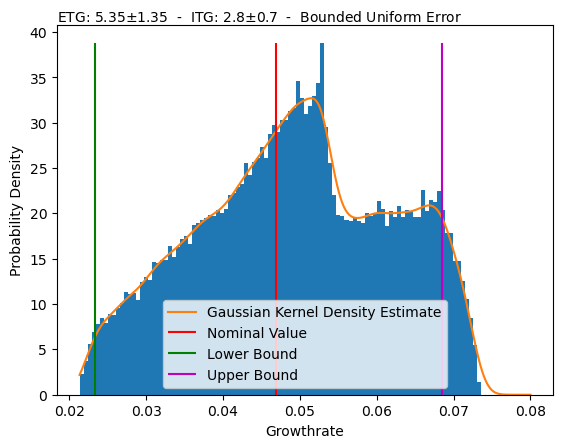

In [21]:
from scipy import stats
growthrates, _ = gpr.predict(uniform.samples_np)
print(data_set.x_train[0:10])
print(data_set.growthrate_train[0:10])

bounds = [(4,6.7), (2.1,3.5)]
nominal_parameters = np.array([np.mean(b) for b in bounds]).reshape((2,1)).T
print('SHAPE', nominal_parameters.shape, data_set.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds]).reshape(2,1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds]).reshape(2,1).T)

kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),0.08, 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Bound')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Bound')
plt.annotate(f'ETG: {nominal_parameters[0][0]}$\pm$1.35  -  ITG: {nominal_parameters[0][1]}$\pm$0.7  -  Bounded Uniform Error',
            xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()

